In [1]:
!pip install datasets transformers librosa jiwer git-lfs accelerate torch audiomentations evaluate wandb tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.5/80.5 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 52.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 41.5 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.0
    Uninstalling scipy-1.14.0:
      Successfully uninstalled scipy-1.14.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cuml 24.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
libpysal 4.9.2 requires packaging>=22, but you have packaging 21.3 which is incompatible.
libpysal 4.9.2 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
momepy 0.

In [2]:
from huggingface_hub import notebook_login

notebook_login()

In [3]:
from datasets import load_dataset, DatasetDict

# Load the dataset
dataset = load_dataset("AILAB-VNUHCM/vivos", trust_remote_code=True)
dataset

Generating train split:   0%|          | 0/11660 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/760 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['speaker_id', 'path', 'audio', 'sentence'],
        num_rows: 11660
    })
    test: Dataset({
        features: ['speaker_id', 'path', 'audio', 'sentence'],
        num_rows: 760
    })
})

In [4]:
# Split the dataset into train, validation, and test sets (80-10-10)
def split_dataset(dataset, train_size=0.8, val_size=0.1):
    # Split the dataset into train and remaining (val+test)
    train_test_split_data = dataset['train'].train_test_split(test_size=1 - train_size)
    train_dataset = train_test_split_data['train']
    remaining_dataset = train_test_split_data['test']

    # Split the remaining dataset into validation and test
    val_test_split_data = remaining_dataset.train_test_split(test_size=val_size / (1 - train_size))
    val_dataset = val_test_split_data['train']
    test_dataset = val_test_split_data['test']

    # Create a DatasetDict
    dataset_dict = DatasetDict({
        'train': train_dataset,
        'validation': val_dataset,
        'test': test_dataset
    })

    return dataset_dict

# Split the dataset
dataset = split_dataset(dataset)

In [5]:
dataset = dataset.select_columns(['audio','sentence'])

In [6]:
# Function to extract duration from audio array and sample rate
def extract_duration(batch):
    audio_array = batch["audio"]["array"]
    sample_rate = batch["audio"]["sampling_rate"]
    batch["duration"] = len(audio_array) / sample_rate
    return batch

# Apply the function to compute duration and add it as a new column
dataset = dataset.map(extract_duration, num_proc=4)

# Verify the dataset with the new duration column
print(dataset)

Map (num_proc=4):   0%|          | 0/9328 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1165 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1167 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['audio', 'sentence', 'duration'],
        num_rows: 9328
    })
    validation: Dataset({
        features: ['audio', 'sentence', 'duration'],
        num_rows: 1165
    })
    test: Dataset({
        features: ['audio', 'sentence', 'duration'],
        num_rows: 1167
    })
})


In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert the datasets to DataFrames
train_df = pd.DataFrame(dataset['train'])
validation_df = pd.DataFrame(dataset['validation'])
test_df = pd.DataFrame(dataset['test'])

# Calculate total duration in hours
def total_duration_in_hours(df):
    total_duration_seconds = df['duration'].sum()
    total_duration_hours = total_duration_seconds / 3600
    return total_duration_hours

train_total_hours = total_duration_in_hours(train_df)
validation_total_hours = total_duration_in_hours(validation_df)
test_total_hours = total_duration_in_hours(test_df)

print(f"Tổng thời lượng của tập huấn luyện: {train_total_hours:.2f} giờ")
print(f"Tổng thời lượng của tập xác thực: {validation_total_hours:.2f} giờ")
print(f"Tổng thời lượng của tập kiểm tra: {test_total_hours:.2f} giờ")

Tổng thời lượng của tập huấn luyện: 11.90 giờ
Tổng thời lượng của tập xác thực: 1.51 giờ
Tổng thời lượng của tập kiểm tra: 1.51 giờ


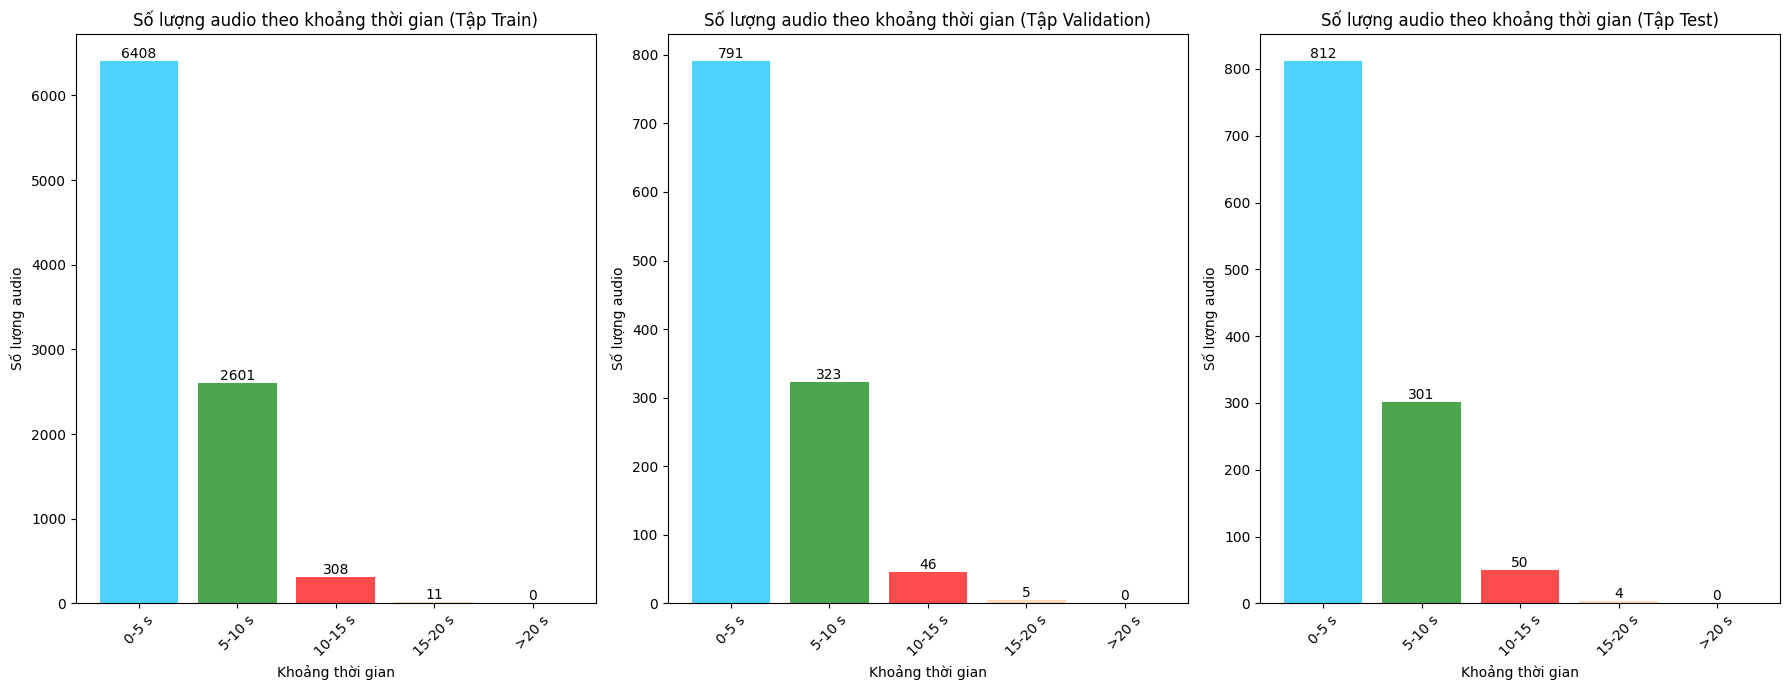

In [8]:
import matplotlib.pyplot as plt

# Count number of audios based on duration
def count_durations(df):
    bins = [0, 5, 10, 15, 20, float('inf')]  # Duration in seconds
    labels = ['0-5 s', '5-10 s', '10-15 s', '15-20 s', '>20 s']
    df['duration_category'] = pd.cut(df['duration'], bins=bins, labels=labels, right=False)
    return df['duration_category'].value_counts().sort_index()

train_duration_counts = count_durations(train_df)
validation_duration_counts = count_durations(validation_df)
test_duration_counts = count_durations(test_df)

# Colors for each duration category
colors = {
    '0-5 s': '#00BFFF',
    '5-10 s': 'green',
    '10-15 s': 'red',
    '15-20 s': '#ffcc99',
    '>20 s': '#c2c2f0'
}

# Plot bar charts for train, validation, and test sets
plt.figure(figsize=(18, 7))

def plot_bar_with_counts(ax, counts, title):
    bars = ax.bar(counts.index, counts, color=[colors[label] for label in counts.index], alpha=0.7)
    ax.set_xlabel('Khoảng thời gian')
    ax.set_ylabel('Số lượng audio')
    ax.set_title(title)
    ax.tick_params(axis='x', rotation=45)

    # Display counts on top of each bar
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f'{int(height)}',
            ha='center',
            va='bottom'
        )

# Bar chart for the training set
plt.subplot(1, 3, 1)
plot_bar_with_counts(plt.gca(), train_duration_counts, 'Số lượng audio theo khoảng thời gian (Tập Train)')

# Bar chart for the validation set
plt.subplot(1, 3, 2)
plot_bar_with_counts(plt.gca(), validation_duration_counts, 'Số lượng audio theo khoảng thời gian (Tập Validation)')

# Bar chart for the test set
plt.subplot(1, 3, 3)
plot_bar_with_counts(plt.gca(), test_duration_counts, 'Số lượng audio theo khoảng thời gian (Tập Test)')

plt.tight_layout()
plt.show()


In [9]:
from datasets import ClassLabel
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)

            df = pd.DataFrame(dataset[picks])
    display(HTML(df.to_html()))

show_random_elements(dataset['train'].remove_columns(["audio"]))

IndentationError: unexpected indent (287121754.py, line 15)

In [7]:
import re

number_to_words = {
    '0': 'KHÔNG',
    '1': 'MỘT',
    '2': 'HAI',
    '3': 'BA',
    '4': 'BỐN',
    '5': 'NĂM',
    '6': 'SÁU',
    '7': 'BẢY',
    '8': 'TÁM',
    '9': 'CHÍN'
}

chars_to_ignore_regex = r'[\,\?\.\!\-\;\:\"]'

def normalize_text(text):
    # Replace numbers with words
    text = re.sub(r'\d', lambda x: number_to_words[x.group()], text)
    # Remove unwanted characters
    text = re.sub(chars_to_ignore_regex, ' ', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    # Convert to lowercase
    text = text.lower()
    return text


In [8]:
dataset = dataset.map(lambda x: {'text': normalize_text(x['sentence'])}, remove_columns=['sentence'])

Map:   0%|          | 0/9328 [00:00<?, ? examples/s]

Map:   0%|          | 0/1165 [00:00<?, ? examples/s]

Map:   0%|          | 0/1167 [00:00<?, ? examples/s]

In [9]:
dataset['train'][3]['audio']

{'path': None,
 'array': array([ 0.00000000e+00,  0.00000000e+00, -3.05175781e-05, ...,
         6.40869141e-04,  5.18798828e-04,  5.79833984e-04]),
 'sampling_rate': 16000}

In [10]:
import IPython.display as ipd
import numpy as np
import random

print(dataset['train'][3]["text"])
ipd.Audio(data=dataset['train'][3]["audio"]["array"], autoplay=True, rate=16000)

trường là người rất có kỷ luật nhưng làm việc hơi cẩu thả một chút


In [11]:
import random
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift
import numpy as np

# Define audio augmentation pipeline
augment = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.01, p=0.1),
    TimeStretch(min_rate=0.8, max_rate=1.1, p=0.2),
    PitchShift(min_semitones=-4, max_semitones=4, p=0.2),
    Shift(min_shift=-0.3, max_shift=0.3, p=0.2),
])

# Function to augment audio
def augment_audio(batch):
    audio = batch["audio"]
    samples = np.array(audio["array"])
    sample_rate = audio["sampling_rate"]

    augmented_samples = augment(samples=samples, sample_rate=sample_rate)

    batch["audio"] = {
        "array": augmented_samples,
        "sampling_rate": sample_rate
    }
    return batch

In [12]:
# Apply audio augmentation
dataset = dataset.map(augment_audio, num_proc=4)

Map (num_proc=4):   0%|          | 0/9328 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/audiomentations/core/transforms_interface.py:62: UserWarning: Warning: input samples dtype is np.float64. Converting to np.float32
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/audiomentations/core/transforms_interface.py:62: UserWarning: Warning: input samples dtype is np.float64. Converting to np.float32
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/audiomentations/core/transforms_interface.py:62: UserWarning: Warning: input samples dtype is np.float64. Converting to np.float32
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/audiomentations/core/transforms_interface.py:62: UserWarning: Warning: input samples dtype is np.float64. Converting to np.float32
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/audiomentations/core/transforms_interface.py:62: UserWarning: Warning: input samples dtype is np.float64. Converting to np.float32
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/audiomentations/core

Map (num_proc=4):   0%|          | 0/1165 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/audiomentations/core/transforms_interface.py:62: UserWarning: Warning: input samples dtype is np.float64. Converting to np.float32
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/audiomentations/core/transforms_interface.py:62: UserWarning: Warning: input samples dtype is np.float64. Converting to np.float32
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/audiomentations/core/transforms_interface.py:62: UserWarning: Warning: input samples dtype is np.float64. Converting to np.float32
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/audiomentations/core/transforms_interface.py:62: UserWarning: Warning: input samples dtype is np.float64. Converting to np.float32
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/audiomentations/core/transforms_interface.py:62: UserWarning: Warning: input samples dtype is np.float64. Converting to np.float32
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/audiomentations/core

Map (num_proc=4):   0%|          | 0/1167 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/audiomentations/core/transforms_interface.py:62: UserWarning: Warning: input samples dtype is np.float64. Converting to np.float32
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/audiomentations/core/transforms_interface.py:62: UserWarning: Warning: input samples dtype is np.float64. Converting to np.float32
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/audiomentations/core/transforms_interface.py:62: UserWarning: Warning: input samples dtype is np.float64. Converting to np.float32
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/audiomentations/core/transforms_interface.py:62: UserWarning: Warning: input samples dtype is np.float64. Converting to np.float32
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/audiomentations/core/transforms_interface.py:62: UserWarning: Warning: input samples dtype is np.float64. Converting to np.float32
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/audiomentations/core

In [13]:
ipd.Audio(data=dataset['train'][3]["audio"]["array"], autoplay=True, rate=16000)

In [14]:
def extract_all_chars(batch):
  all_text = " ".join(batch["text"])
  vocab = list(set(all_text))
  return {"vocab": [vocab], "all_text": [all_text]}

In [15]:
vocab_train = dataset["train"].map(extract_all_chars, batched=True, batch_size=-1, keep_in_memory=True, remove_columns=dataset["train"].column_names)
vocal_validation = dataset["validation"].map(extract_all_chars, batched=True, batch_size=-1, keep_in_memory=True, remove_columns=dataset["validation"].column_names)

Map:   0%|          | 0/9328 [00:00<?, ? examples/s]

Map:   0%|          | 0/1165 [00:00<?, ? examples/s]

In [16]:
vocab_list = list(set(vocab_train["vocab"][0]) | set(vocal_validation["vocab"][0]))

In [17]:
vocab_dict = {v: k for k, v in enumerate(sorted(vocab_list))}
vocab_dict

{' ': 0,
 'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'g': 6,
 'h': 7,
 'i': 8,
 'k': 9,
 'l': 10,
 'm': 11,
 'n': 12,
 'o': 13,
 'p': 14,
 'q': 15,
 'r': 16,
 's': 17,
 't': 18,
 'u': 19,
 'v': 20,
 'x': 21,
 'y': 22,
 'à': 23,
 'á': 24,
 'â': 25,
 'ã': 26,
 'è': 27,
 'é': 28,
 'ê': 29,
 'ì': 30,
 'í': 31,
 'ò': 32,
 'ó': 33,
 'ô': 34,
 'õ': 35,
 'ù': 36,
 'ú': 37,
 'ý': 38,
 'ă': 39,
 'đ': 40,
 'ĩ': 41,
 'ũ': 42,
 'ơ': 43,
 'ư': 44,
 'ạ': 45,
 'ả': 46,
 'ấ': 47,
 'ầ': 48,
 'ẩ': 49,
 'ẫ': 50,
 'ậ': 51,
 'ắ': 52,
 'ằ': 53,
 'ẳ': 54,
 'ẵ': 55,
 'ặ': 56,
 'ẹ': 57,
 'ẻ': 58,
 'ẽ': 59,
 'ế': 60,
 'ề': 61,
 'ể': 62,
 'ễ': 63,
 'ệ': 64,
 'ỉ': 65,
 'ị': 66,
 'ọ': 67,
 'ỏ': 68,
 'ố': 69,
 'ồ': 70,
 'ổ': 71,
 'ỗ': 72,
 'ộ': 73,
 'ớ': 74,
 'ờ': 75,
 'ở': 76,
 'ỡ': 77,
 'ợ': 78,
 'ụ': 79,
 'ủ': 80,
 'ứ': 81,
 'ừ': 82,
 'ử': 83,
 'ữ': 84,
 'ự': 85,
 'ỳ': 86,
 'ỵ': 87,
 'ỷ': 88,
 'ỹ': 89}

In [18]:
# Thêm kí tự ngăn cách các từ
vocab_dict["|"] = vocab_dict[" "]
del vocab_dict[" "]
# Đại diện cho các từ không có trong từ vựng, hữu ích khi xử lý các từ lạ
vocab_dict["[UNK]"] = len(vocab_dict)
# Thêm padding vào các chuỗi có độ dài khác nhau, giúp chuẩn hóa kích thước đầu vào
vocab_dict["[PAD]"] = len(vocab_dict)
len(vocab_dict)

92

In [19]:
import json
with open('vocab.json', 'w') as vocab_file:
    json.dump(vocab_dict, vocab_file)

In [20]:
from transformers import Wav2Vec2CTCTokenizer

tokenizer = Wav2Vec2CTCTokenizer.from_pretrained("./", unk_token="[UNK]", pad_token="[PAD]", word_delimiter_token="|")


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [21]:
from transformers import Wav2Vec2FeatureExtractor
feature_extractor = Wav2Vec2FeatureExtractor(feature_size=1, sampling_rate=16000, padding_value=0.0, do_normalize=True, return_attention_mask=False)

In [22]:
from transformers import Wav2Vec2Processor
processor = Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)

In [23]:
def prepare_dataset(batch):
    audio = batch["audio"]

    # batched output is "un-batched"
    batch["input_values"] = processor(audio["array"], sampling_rate=16000).input_values[0]
    batch["input_length"] = len(batch["input_values"])

    with processor.as_target_processor():
        batch["labels"] = processor(batch["text"]).input_ids
    return batch

In [24]:
dataset['train'] = dataset['train'].map(prepare_dataset, remove_columns=dataset['train'].column_names, num_proc=4)
dataset['validation'] = dataset['validation'].map(prepare_dataset, remove_columns=dataset['validation'].column_names, num_proc=4)

Map (num_proc=4):   0%|          | 0/9328 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:157: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:157: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:157: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call

Map (num_proc=4):   0%|          | 0/1165 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:157: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:157: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:157: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call

In [25]:
import torch

from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union

@dataclass
class DataCollatorCTCWithPadding:
    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lengths and need
        # different padding methods
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            return_tensors="pt",
        )

        # Process labels using the `text` argument in a separate call
        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                return_tensors="pt",
            )

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch["attention_mask"].ne(1), -100)

        batch["labels"] = labels

        return batch


In [26]:
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)

In [27]:
import numpy as np
from datasets import load_metric

wer_metric = load_metric("wer", trust_remote_code=True)

def compute_metrics(pred):
    pred_logits = pred.predictions
    pred_ids = np.argmax(pred_logits, axis=-1)

    pred.label_ids[pred.label_ids == -100] = processor.tokenizer.pad_token_id

    pred_str = processor.batch_decode(pred_ids)
    # we do not want to group tokens when computing the metrics
    label_str = processor.batch_decode(pred.label_ids, group_tokens=False)

    # Compute WER
    wer = wer_metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}

/tmp/ipykernel_36/1184743665.py:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  wer_metric = load_metric("wer", trust_remote_code=True)


In [28]:
from transformers import Wav2Vec2ForCTC

model = Wav2Vec2ForCTC.from_pretrained(
    "facebook/wav2vec2-base",
    attention_dropout=0.0,
    hidden_dropout=0.0,
    feat_proj_dropout=0.0,
    mask_time_prob=0.0,
    layerdrop=0.05,
    ctc_loss_reduction="mean",
    pad_token_id=processor.tokenizer.pad_token_id,
    vocab_size=len(processor.tokenizer),
)

config.json:   0%|          | 0.00/1.84k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/configuration_utils.py:364: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/380M [00:00<?, ?B/s]

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['lm_head.bias', 'lm_head.weight', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [29]:
model.freeze_feature_extractor()

/opt/conda/lib/python3.10/site-packages/transformers/models/wav2vec2/modeling_wav2vec2.py:2177: FutureWarning: The method `freeze_feature_extractor` is deprecated and will be removed in Transformers v5. Please use the equivalent `freeze_feature_encoder` method instead.
  warnings.warn(


In [34]:
!wandb login edfa6bb2b01b5b2e74dd9f112d7ba0da853ebd0e

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [35]:
from transformers import TrainingArguments
import wandb

wandb.init(project="Wav2Vec2")

training_args = TrainingArguments(
    output_dir="wav2vec2-vivos-asr",
    group_by_length=True,
    per_device_train_batch_size=32,
    eval_strategy="steps",
    num_train_epochs=20,
    fp16=True,
    gradient_accumulation_steps=4,
    dataloader_num_workers=4,
    gradient_checkpointing=True,
    save_steps=146,
    eval_steps=146,
    logging_steps=146,
    learning_rate=1e-4,
    weight_decay=0.01,
    warmup_steps=400,
    save_total_limit=2,
    push_to_hub=True,
    lr_scheduler_type="cosine",
    report_to="wandb", 
)

eval/loss,▂▁▁▃▅█
eval/runtime,▃▇██▁▁
eval/samples_per_second,▆▂▁▁██
eval/steps_per_second,▆▂▁▁██
eval/wer,▁▁▁▁▁▁
train/epoch,▁▁▂▂▄▄▅▅▇▇██
train/global_step,▁▁▂▂▄▄▅▅▇▇██
train/grad_norm,█▃▁▂█▆
train/learning_rate,▁██▆▄▁
train/loss,█▁▂▁▁▁
eval/loss,4.17691


In [36]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=dataset['train'],
    eval_dataset=dataset['validation'],
    tokenizer=processor.feature_extractor,
)

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


In [ ]:
trainer.train()

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:157: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:157: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/opt/conda/lib/python3.10/site

Step,Training Loss,Validation Loss,Wer
146,3.482000,4.240541,1.000000
292,3.479800,4.283187,1.000000
438,3.487600,4.179955,1.000000
584,3.481200,4.227350,1.000000
730,3.482100,4.197381,1.000000
876,3.480000,4.237356,1.000000


/opt/conda/lib/python3.10/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:157: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:157: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:157: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call

In [ ]:
trainer.evaluate()

In [ ]:
trainer.push_to_hub()

In [ ]:
from transformers import AutoModelForCTC, Wav2Vec2Processor

model = AutoModelForCTC.from_pretrained("Thienpkae/wav2vec2-vivos-asr")

tokenizer = Wav2Vec2CTCTokenizer("./vocab.json", unk_token="[UNK]", pad_token="[PAD]", word_delimiter_token="|")
feature_extractor = Wav2Vec2FeatureExtractor(feature_size=1, sampling_rate=16000, padding_value=0.0, do_normalize=True, return_attention_mask=False)
processor = Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)

In [ ]:
# Function to prepare input
def prepare_input(batch):
    audio = batch["audio"]
    inputs = processor(audio["array"], sampling_rate=audio["sampling_rate"], return_tensors="pt", padding=True)
    batch["input_values"] = inputs.input_values.squeeze().tolist()  # Convert to list to avoid tensor in map function
    return batch

In [ ]:
test_dataset = dataset["test"].map(prepare_input)

In [ ]:
model = model.to('cuda')
model.eval()

In [ ]:
test_dataset

In [ ]:
import torch

def predict(batch):
     # Convert input values to tensor, add batch dimension, and move to GPU
    input_values = torch.tensor(batch["input_values"]).unsqueeze(0).to('cuda')
    
    # Disable gradient calculations for inference
    with torch.no_grad():
        # Perform the forward pass
        logits = model(input_values).logits
        
    # Get the predicted token IDs
    pred_ids = torch.argmax(logits, dim=-1)
    
    # Decode the predictions and add them to the batch
    batch["predicted_text"] = processor.batch_decode(pred_ids.cpu().numpy())[0]  # Move to CPU before converting to numpy

    # If 'text' is in the batch, add it (assuming 'text' might be used for comparison or evaluation)
    if 'text' in batch:
        batch["text"] = batch["text"]
    else:
        batch["text"] = None  # Handle missing 'text' as needed
    
    return batch

# Apply the prediction function to the test dataset
result = test_dataset.map(lambda batch: predict(batch), remove_columns=['audio', 'input_values'])


In [ ]:
show_random_elements(result)

In [ ]:
# Evaluate the results
wer_metric = load_metric("wer")
references = [item["text"] for item in test_dataset]
predictions = [item["predicted_text"] for item in result]

wer = wer_metric.compute(predictions=predictions, references=references)
print(f"Word Error Rate (WER): {wer:.2f}")